<a href="https://colab.research.google.com/github/YonDraco/learn-deep-learning/blob/main/Fourth_FashionMNIST_CNNAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convolutional Autoencoders

Sử dụng các lớp chập để xây dựng bộ mã tự động của mình. Điều này thường dẫn đến kết quả tốt hơn so với các networks dense, data [Fashion MNIST dataset](https://www.tensorflow.org/datasets/catalog/fashion_mnist).

## Imports

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

## Prepare the Dataset

Tải data train và test từ TFDS. Tôi không làm phẳng hình ảnh lần này. Đó là bởi vì tôi sẽ sử dụng các lớp phức hợp sau này có thể xử lý các hình ảnh 2D.

In [2]:
def map_image(image, label):
  '''Chuẩn hóa hình ảnh. Trả về hình ảnh dưới dạng đầu vào và nhãn.'''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0

  return image, image

In [3]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('fashion_mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('fashion_mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteJWS0WF/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteJWS0WF/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


## Define the Model

Sử dụng các lớp phức hợp để xây dựng mô hình. Điều này bao gồm ba phần chính: bộ mã hóa, nút cổ chai và bộ giải mã. Bạn sẽ làm theo cấu hình hiển thị trong hình dưới đây.

<img src="https://drive.google.com/uc?export=view&id=15zh7bst9KKvciRdCvMAH7kXt3nNkABzO" width="75%" height="75%"/>

Bộ mã hóa, giống như trong các phòng thí nghiệm trước đây, sẽ hợp đồng với mỗi lớp bổ sung. Các tính năng được tạo bằng các lớp Conv2D trong khi các lớp tổng hợp tối đa làm giảm kích thước.

In [4]:
def encoder(inputs):
  '''Xác định bộ mã hóa với hai lớp tổng hợp Conv2D và MaxPooling2D.'''
  conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(max_pool_1)
  max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)

  return max_pool_2

Một lớp nút cổ chai được sử dụng để có nhiều tính năng hơn nhưng không làm giảm thêm kích thước sau đó. Một lớp khác được chèn vào đây để hiển thị đầu ra của bộ mã hóa.

In [5]:
def bottle_neck(inputs):
  '''Xác định nút cổ chai.'''
  bottle_neck = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  encoder_visualization = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(bottle_neck)

  return bottle_neck, encoder_visualization

Bộ giải mã sẽ lấy mẫu đầu ra tắc nghẽn trở lại kích thước hình ảnh ban đầu.

In [6]:
def decoder(inputs):
  '''Xác định đường dẫn bộ giải mã để lấy mẫu trở lại kích thước hình ảnh ban đầu.'''
  conv_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  up_sample_1 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(up_sample_1)
  up_sample_2 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_2)

  conv_3 = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(up_sample_2)

  return conv_3

Bây giờ bạn có thể xây dựng bộ mã tự động đầy đủ bằng cách sử dụng các chức năng ở trên.

In [7]:
def convolutional_auto_encoder():
  '''xây dựng autoencoder model.'''
  inputs = tf.keras.layers.Input(shape=(28, 28, 1,))
  encoder_output = encoder(inputs)
  bottleneck_output, encoder_visualization = bottle_neck(encoder_output)
  decoder_output = decoder(bottleneck_output)
  
  model = tf.keras.Model(inputs =inputs, outputs=decoder_output)
  encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_visualization)
  return model, encoder_model


In [8]:
convolutional_model, convolutional_encoder_model = convolutional_auto_encoder()
convolutional_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         295040

## Compile and Train the model

In [9]:
train_steps = 60000 // BATCH_SIZE
valid_steps = 60000 // BATCH_SIZE

convolutional_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy')
conv_model_history = convolutional_model.fit(train_dataset, steps_per_epoch=train_steps, validation_data=test_dataset, validation_steps=valid_steps, epochs=40)

Epoch 1/40
468/468 [==============================] - 48s 32ms/step - loss: 0.3225 - val_loss: 0.2688
Epoch 2/40
468/468 [==============================] - 13s 26ms/step - loss: 0.2614 - val_loss: 0.2581
Epoch 3/40
468/468 [==============================] - 12s 26ms/step - loss: 0.2550 - val_loss: 0.2550
Epoch 4/40
468/468 [==============================] - 12s 26ms/step - loss: 0.2525 - val_loss: 0.2531
Epoch 5/40
468/468 [==============================] - 12s 26ms/step - loss: 0.2510 - val_loss: 0.2525
Epoch 6/40
468/468 [==============================] - 12s 26ms/step - loss: 0.2500 - val_loss: 0.2521
Epoch 7/40
468/468 [==============================] - 12s 26ms/step - loss: 0.2493 - val_loss: 0.2507
Epoch 8/40
468/468 [==============================] - 12s 26ms/step - loss: 0.2484 - val_loss: 0.2504
Epoch 9/40
468/468 [==============================] - 12s 26ms/step - loss: 0.2483 - val_loss: 0.2498
Epoch 10/40
468/468 [==============================] - 12s 26ms/step - loss: 0.247

## Display sample results

Như thường lệ, ta hãy xem một số kết quả mẫu từ mô hình được đào tạo.

In [10]:
def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Hiển thị kết quả đầu ra mẫu trong một hàng.'''
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
  '''Hiển thị input, encoded, and decoded output values.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(28,28,))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(28,28,))

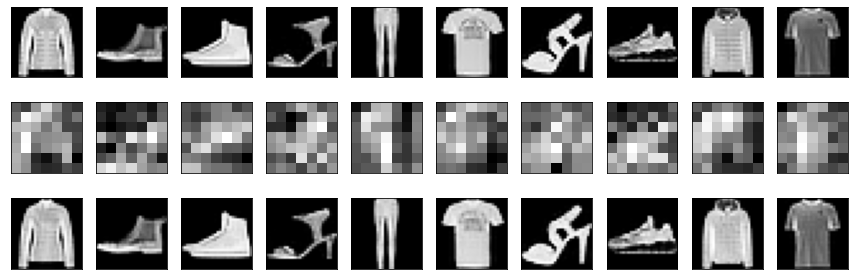

In [11]:
# Lấy 1 batch của dataset
test_dataset = test_dataset.take(1)

# lấy input images and đặt nó vào danh sách
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# chọn 10 chỉ số
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# chuẩn bị các mẫu thử nghiệm dưới dạng 1 batch gồm 10 hình ảnh
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10, 28, 28, 1))

# lấy encoder ouput
encoded = convolutional_encoder_model.predict(conv_output_samples)

# nhận dự đoán cho một số giá trị trong tập dữ liệu
predicted = convolutional_model.predict(conv_output_samples)

# hiển thị các mẫu, mã hóa và giá trị đã giải mã!
display_results(conv_output_samples, encoded, predicted, enc_shape=(7,7))